In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mixbox
import plotly.express as px
import math

plt.rcParams.update({'font.size': 12})
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

## Project Overview

Color mixing with a limited palette is a fundamental skill in oil painting. It's really important to learn how target colors can be created as a combination of available pigments, and using different palettes can result in very different paintings (as shown in the three paintings below by TJ Cunningham using various three-pigment palettes). Experts are able to do this by intuition, but beginners do a lot of trial and error when starting out. 

<img src="cunningham_1.png" width="300">
<img src="cunningham_2.png" width="300">
<img src="cunningham_3.png" width="300">

My idea is to make a tool that can help beginner oil painters with choosing colors and building intuition. The main functionality will be to project images into different bases of real pigments, with the option of determining the "optimal" basis that explains the most variance in color of the full image. 

## Literature Context 

Sochorová and Jamriška 2021 ["Practical Pigment Mixing for Digital Painting"](https://scrtwpns.com/mixbox.pdf) uses a similar framework of mixing colors in a pigment-based latent space for digital painting software. They demonstrate with a specific pigment selection that is fairly close to CMYK and thus covers the broadest gamut. My project will instead focus on showing how pigment selections with a limited gamut can change the effect and mood in by a painting, as a tool for a traditional painter to explore different palettes. They have some [public code](https://github.com/scrtwpns/mixbox/blob/master/python/mixbox.py) available that I referenced for projecting into latent spaces.  


## Outline

1. [**Pigment spectral data**](#data) - importing the pigment spectral responses upon which the color mixing is based
2. [**Converting spectral data to RGB**](#convert) - calculate RGB values for each of the pigments 
3. [**Finding palette gamut**](#gamut) - given a 3-color palette, calculate the palette gamut
4. [**Projecting into palette gamut**](#project) - given a 3-color palette, transforming the image from its original RGB gamut to fit into the palette gamut
5. [**Displaying projections for specified pigment selection**](#display) - frontend code for showing images projected into a given palette
6. [**Examples**](#examples) - demonstrating functionality on various example images

<a id='data'></a>

## 1. Pigment Spectral Data 

I am using the Fiber Optics Reflectance Spectra (FORS) [database](https://chsopensource.org/fors/) that contains spectral responses of 54 historical pigments (listed below) commonly used in art work. 

This database contains spectra for pigments mixed with various media that are commonly used in painting, for example gum arabic which is used to bind watercolor paints, or egg yolks which are used to make tempera paint. Within this project, I am only using the spectral responses of pigments mixed with linseed oil, which is the binder used to mix oil paints. Spectral responses for a few common pigments are shown in the plot below. 

In [130]:
df = pd.read_csv("linseed_oil.csv")
# cutting out columns for wavelength and linseed oil
pigments = list(df.columns[1:-1]) 
pigments

['burntumber',
 'rawumber',
 'vandykebrown',
 'burntsienna',
 'rawsienna',
 'redochre',
 'redlead',
 'cadmiumred',
 'alizarin',
 'madderlake',
 'lacdye',
 'carminelake',
 'vermilion',
 'realgar',
 'yellowlakeresed',
 'massicot',
 'yellowochre',
 'gamboge',
 'naplesyellow',
 'leadtinyellow..II',
 'leadtinyellow..I',
 'saffron',
 'orpiment',
 'cobaltyellow',
 'cadmiumyellow',
 'chromegreen',
 'cobaltgreen',
 'cadmiumgreen',
 'greenearth',
 'viridian',
 'phthalogreen',
 'verdigris',
 'malachite',
 'bluebice',
 'cobaltblue',
 'azurite',
 'egyptianblue',
 'ultramarine',
 'phthaloblue',
 'smalt',
 'indigo',
 'mayablue',
 'prussianblue',
 'cobaltviolet',
 'ivoryblack',
 'vineblack',
 'boneblack',
 'lampblaxk',
 'gypsum',
 'chalk',
 'leadwhite',
 'zincwhite',
 'titaniumwhite',
 'lithopone']

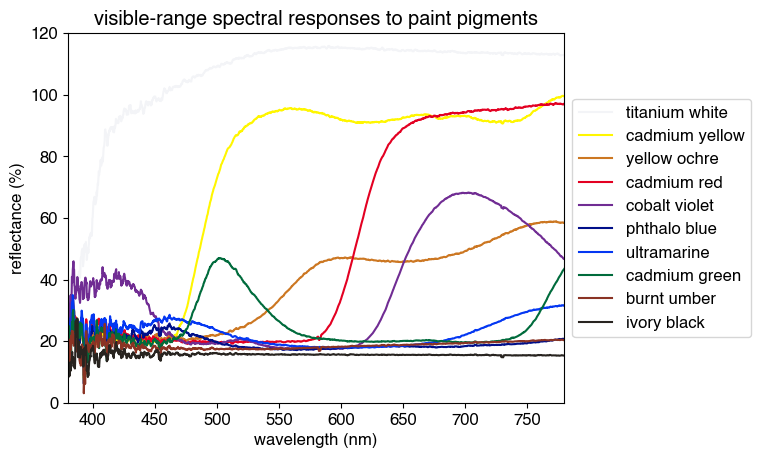

In [131]:
plt.figure()    
plt.plot(df["A"],df['titaniumwhite'],c='#F3F4F7',label='titanium white')
plt.plot(df["A"],df['cadmiumyellow'],c='#fff600',label='cadmium yellow')
plt.plot(df["A"],df['yellowochre'],c='#CC7722',label='yellow ochre')
plt.plot(df["A"],df['cadmiumred'],c='#e30022',label='cadmium red')
plt.plot(df["A"],df['cobaltviolet'],c='#702c93',label='cobalt violet')
plt.plot(df["A"],df['phthaloblue'],c='#000F89',label='phthalo blue')
plt.plot(df["A"],df['ultramarine'],c='#0437F2',label='ultramarine')
plt.plot(df["A"],df['cadmiumgreen'],c='#006b3c',label='cadmium green')
plt.plot(df["A"],df['burntumber'],c='#8a3324',label='burnt umber')
plt.plot(df["A"],df['ivoryblack'],c='#282420',label='ivory black')
plt.ylabel("reflectance (%)")
plt.xlabel("wavelength (nm)")
plt.xlim(380,780)
plt.ylim(0,120)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("visible-range spectral responses to paint pigments")
plt.show()

In [132]:
# find the wavelengths in the spectral data that cover the visible range
blue_ind = np.where(df["A"]>380)[0][0] # wavelength at blue end of visible range
red_ind = np.where(df["A"]<700)[0][-1] # wavelength at red end of visible range
lams = np.array(df["A"][blue_ind:red_ind]) # all visible wavelengths

<a id='convert'></a>

## 2. Converting Spectral Data to RGB

We can transfer hyperspectral colors to the CIE XYZ color space with the following [equations](https://en.wikipedia.org/wiki/CIE_1931_color_space), which can then be transferred to RGB:

$
X = \frac{K}{N}\int \bar{x}(\lambda)S(\lambda)I(\lambda)d\lambda 
$

$
Y = \frac{K}{N}\int \bar{y}(\lambda)S(\lambda)I(\lambda)d\lambda 
$

$
Z = \frac{K}{N}\int \bar{z}(\lambda)S(\lambda)I(\lambda)d\lambda 
$

$
N = \int \bar{y}(\lambda)I(\lambda)d\lambda
$

Where K is a scaling factor, S is the spectral reflectance, I is the reference illuminant for which I use [D65](http://www.npsg.uwaterloo.ca/data/illuminant.php), data from Hunt 1991. $\bar{x}$, $\bar{y}$, and $\bar{z}$ are standard observer chromatic responses given by CIE color matching functions plotted below.

Sources: [Spectral to CIE 1931 color space ("XYZ")](http://www.brucelindbloom.com/index.html?Eqn_Spect_to_XYZ.html), [XYZ to RGB](http://www.brucelindbloom.com/index.html?Eqn_XYZ_to_RGB.html)

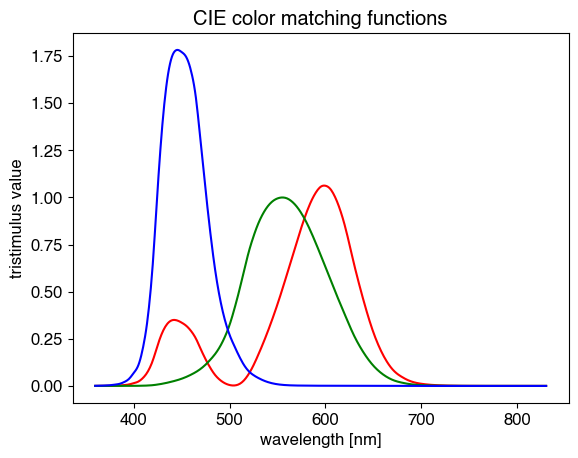

In [133]:
# load CIE 1931 standard observer datafile 
table = np.load('CIEXYZ_1931_table.npy')

plt.figure()
plt.plot(table[:,0],table[:,1],c='red')
plt.plot(table[:,0],table[:,2],c='green')
plt.plot(table[:,0],table[:,3],c='blue')

plt.title("CIE color matching functions")
plt.xlabel("wavelength [nm]")
plt.ylabel("tristimulus value")
plt.show()

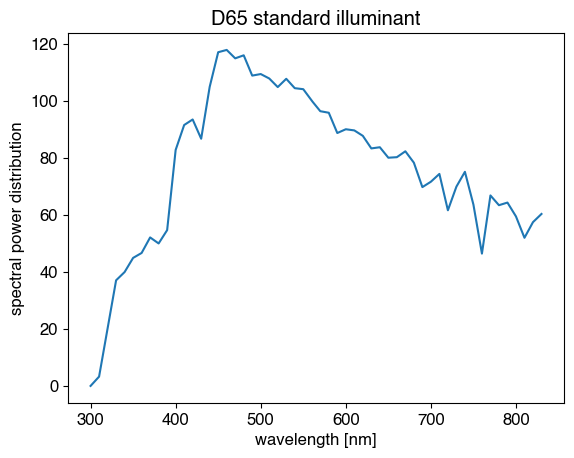

In [134]:
# load CIE 1931 standard observer datafile 
d65 = pd.read_csv('d65.csv')

plt.figure()
plt.plot(d65['wavelength'],d65['power'])
plt.title("D65 standard illuminant")
plt.xlabel("wavelength [nm]")
plt.ylabel("spectral power distribution")
plt.show()

In [135]:
def spec_RGB(spec, lams, ill="D65",hx=True):
    """
    spec: reflectance measurements
    lams: wavelengths at which reflectance is measured
    ill: standard illuminant
    hx: whether to return hex code
    """
    # load and process CIE 1931 standard observer data
    table = np.load('CIEXYZ_1931_table.npy')
    # find bounds of visible range
    start = np.argmin(np.abs(np.round(lams[0])-table[:,0]))
    end = np.argmin(np.abs(np.round(lams[-1])-table[:,0]))
    
    # normalization terms
    N = np.sum(table[start:end][:,2])
    K = 2.2
    
    X,Y,Z,N = 0,0,0,0
    # do integrals over visible wavelengths
    for i in range(start,end+1):
        if ill=="D65":
            I = d65['power'][np.where(d65['wavelength']==table[i,0])[0][0]]
        if ill=='E':
            I=100
        lams_i = np.argmin(np.abs(table[i,0]-lams))
        X += table[i,1] * spec[lams_i] * I
        Y += table[i,2] * spec[lams_i] * I
        Z += table[i,3] * spec[lams_i] * I
        N += table[i,2] * I
            
    xyz_data = np.array([K*X/N,K*Y/N,K*Z/N])
    
    # two different matrices for moving from XYZ to RGB space
    # one for D65 illuminant and one for E
    xyz2rgb_D65 = np.asarray([ 2.0413690, -0.5649464, -0.3446944,
                           -0.9692660,  1.8760108,  0.0415560,
                           0.0134474, -0.1183897,  1.0154096]).reshape(3,3)
    xyz2rgb_D65 = np.asarray([2.9515373, -1.2894116, -0.4738445,
-1.0851093,  1.9908566,  0.0372026,
 0.0854934, -0.2694964,  1.0912975]).reshape(3,3)
    
     
    
    xyz2rgb_E = np.asarray([ 2.3706743, -0.9000405, -0.4706338,
                        -0.5138850,  1.4253036,  0.0885814,
                         0.0052982, -0.0146949,  1.0093968]).reshape(3,3)
    if ill=="D65":
        rgb_data = xyz2rgb_D65 @ xyz_data
    if ill=="E":
        rgb_data = xyz2rgb_E @ xyz_data
        
    if hx==False:
        return (int(rgb_data[0]),
                int(rgb_data[1]),
                int(rgb_data[2]))
    else:
        return '#{:02x}{:02x}{:02x}'.format(int(rgb_data[0]),
                                    int(rgb_data[1]),
                                    int(rgb_data[2]))

In [8]:
# return hex code for color of "alizarin" pigment
spec_RGB((np.array(df["alizarin"][blue_ind:red_ind])),lams)

'#982228'

In [9]:
# return RGB values for color of "viridian" pigment
spec_RGB((np.array(df["viridian"][blue_ind:red_ind])),
         lams,hx=False)

(33, 46, 44)

In [26]:
rgb_vals = {}
for color in pigments:
    rgb_vals[color] = spec_RGB((np.array(df[color][blue_ind:red_ind])),
         lams,hx=False)
print(rgb_vals)

{'burntumber': (40, 38, 39), 'rawumber': (43, 40, 40), 'vandykebrown': (1397, 1194, 962), 'burntsienna': (40, 39, 40), 'rawsienna': (81, 52, 41), 'redochre': (62, 40, 40), 'redlead': (227, 56, 40), 'cadmiumred': (125, 36, 44), 'alizarin': (152, 34, 40), 'madderlake': (182, 76, 64), 'lacdye': (94, 44, 47), 'carminelake': (76, 30, 37), 'vermilion': (114, 40, 44), 'realgar': (180, 68, 40), 'yellowlakeresed': (127, 76, 35), 'massicot': (140, 124, 73), 'yellowochre': (116, 68, 41), 'gamboge': (194, 122, 40), 'naplesyellow': (174, 119, 44), 'leadtinyellow..II': (209, 148, 45), 'leadtinyellow..I': (214, 207, 95), 'saffron': (196, 127, 49), 'orpiment': (177, 126, 41), 'cobaltyellow': (174, 114, 29), 'cadmiumyellow': (208, 210, 32), 'chromegreen': (45, 61, 45), 'cobaltgreen': (36, 67, 47), 'cadmiumgreen': (29, 74, 47), 'greenearth': (50, 50, 43), 'viridian': (33, 46, 44), 'phthalogreen': (31, 46, 44), 'verdigris': (37, 76, 76), 'malachite': (39, 68, 53), 'bluebice': (47, 78, 66), 'cobaltblue': 

<a id='gamut'></a>

## 3. Finding Palette Gamut

First, I measure the gamut of a 3-color palette by generating a grid of paint mixtures. 

In [81]:
c1 = 'alizarin'
c2 = 'cadmiumyellow'
c3 = 'prussianblue'

z1 = mixbox.rgb_to_latent(rgb_vals[c1])
z2 = mixbox.rgb_to_latent(rgb_vals[c2])
z3 = mixbox.rgb_to_latent(rgb_vals[c3])

In [82]:
grid = [[0,0,1],
        [0,0.25,0.75],
        [0,0.5,0.5],
        [0,0.75,0.25],
        [0,1,0],
        [0.25,0,0.75],
        [0.25,0.25,0.5],
        [0.25,0.5,0.25],
        [0.25,0.75,0],
        [0.5,0,0.5],
        [0.5,0.25,0.25],
        [0.5,0.5,0],
        [0.75,0,0.25],
        [0.75,0.25,0],
        [1,0,0],
        [0.33,0.33,0.34]]

In [83]:
def mix(weights,z1,z2,z3):
    z_mix = [0] * mixbox.LATENT_SIZE
    
    for i in range(len(z_mix)):
        z_mix[i] = (weights[0]*z1[i] +
                    weights[1]*z2[i] +
                    weights[2]*z3[i])
    rgb_mix = mixbox.latent_to_rgb(z_mix)
    
    # add a number of transparencies so that white canvas is the 
    # tacit fourth color in the palette
    return [mixbox.lerp((255,255,255),rgb_mix,0.25),
            mixbox.lerp((255,255,255),rgb_mix,0.5),
            mixbox.lerp((255,255,255),rgb_mix,0.75),
            mixbox.lerp((255,255,255),rgb_mix,1)]

In [84]:
colors = [(255,255,255)]
for combo in grid:
    colors += mix(combo,z1,z2,z3)
colors_df = pd.DataFrame({"R":np.array(colors)[:,0],
                         "G":np.array(colors)[:,1],
                         "B":np.array(colors)[:,2]})

In [85]:
fig = px.scatter_3d(colors_df,x="R",y="G",z="B")
fig.show()

<a id='project'></a>

## 4. Projecting into Palette Gamut

Next, I compress a given image into the palette gamut. There are a few methods for doing this:

1. **Clipping**: you can "clip" the original gamut, which simply approximates any out-of-gamut colors as the closest in-gamut color. This process is not reversible, as multiple out-of-gamut colors can be clipped to the same value in-gamut. It also loses some information by removing contrast in out-of-gamut areas
2. **Distorting RGB**: you can distort the RGB cube to fit inside the new gamut; thus any values within RGB have a one-to-one mapping onto a value in the new gamut. 
3. **Distorting image gamut**: you can distort the gamut of the image (which is generally smaller than RGB) to fit inside the gamut of the palette. This would be the optimal method for preserving information and maximizing contrast as well as use of the palette gamut for the given image. 

For the purpose of time, I will be implementing the "clipping" method here and using nearest neighbor to the gamut grid from above as a shortcut. 

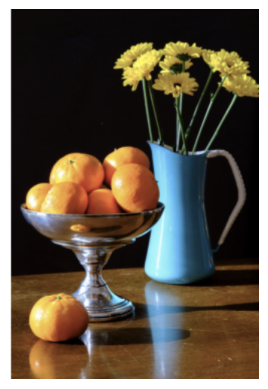

(490, 330, 4)

In [74]:
oranges = plt.imread("./oranges.png")
plt.imshow(oranges)
plt.axis("off")
plt.show()
oranges.shape

In [93]:
oranges_pixels = oranges.reshape(oranges.shape[0]*oranges.shape[1],4)[:,:3]*255

In [196]:
# nearest neighbor inside the grid
def nn(rgb,colors):
    dists = [math.dist(rgb,color) for color in colors]
    return(np.argmin(dists))

In [197]:
# please don't judge me for my nested for loops lol
for i in range(len(oranges_pixels)):
    oranges_pixels[i] = colors[nn(oranges_pixels[i],colors)]

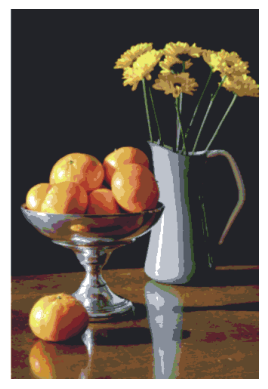

In [198]:
plt.imshow(oranges_pixels.reshape(oranges.shape[0],oranges.shape[1],3)/255)
plt.axis("off")
plt.show()

<a id='display'></a>

## 5. Displaying Projections into Specified Pigment Selection

Making a function to put together the parts of (4).

In [199]:
def show_projection(image_file,pigments,show_original=False,show_gamut=False):
    
    z1 = mixbox.rgb_to_latent(rgb_vals[pigments[0]])
    z2 = mixbox.rgb_to_latent(rgb_vals[pigments[1]])
    z3 = mixbox.rgb_to_latent(rgb_vals[pigments[2]])
    
    colors = [(255,255,255)]
    for combo in grid:
        colors += mix(combo,z1,z2,z3)
        
    if show_gamut==True:
        print("gamut for given palette:")
        colors_df = pd.DataFrame({"R":np.array(colors)[:,0],
                             "G":np.array(colors)[:,1],
                             "B":np.array(colors)[:,2]})
        fig = px.scatter_3d(colors_df,x="R",y="G",z="B")
        fig.show()
    
    img = plt.imread(image_file)
    
    
    flat_pixels = img.reshape(img.shape[0]*img.shape[1],4)[:,:3]*255
    for i in range(len(flat_pixels)):
        flat_pixels[i] = colors[nn(flat_pixels[i],colors)]
        
    if show_original==True:
        f, ax = plt.subplots(1,2)
        ax[0].imshow(img)
        ax[0].title.set_text("original")
        ax[1].imshow(flat_pixels.reshape(img.shape[0],img.shape[1],3)/255)
        ax[0].axis("off")
        ax[1].axis("off")
        ax[1].title.set_text("clipped to palette gamut")
        plt.show()

    else:
        plt.imshow(flat_pixels.reshape(img.shape[0],img.shape[1],3)/255)
        plt.axis("off")
        plt.title("clipped to palette gamut")
        plt.show()
    


<a id='examples'></a>

## 6. Examples

A few examples shown below demonstrate the kind of tones that can when achieved by painting various images with different limited palettes. The more limited the palette gamut, the more it changes the mood of the painting. However, it is often possible to create a wide gamut with a limited number of colors. 

For each example, I will try to find a pigment combination that best recreates the colors of the original, then I will find a few combinations that significantly change the tone of the image. 

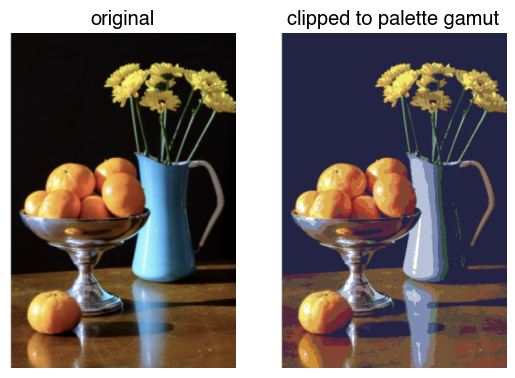

In [200]:
show_projection("oranges.png",["alizarin","cadmiumyellow","smalt"],show_original=True)

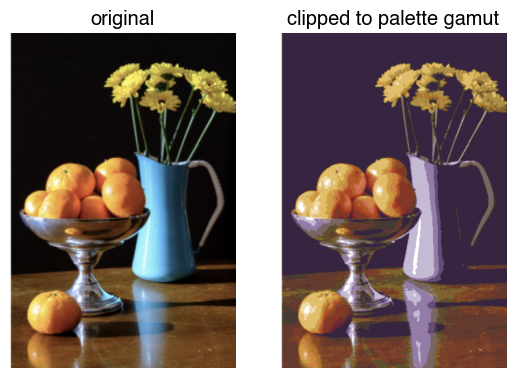

In [201]:
show_projection("oranges.png",["alizarin","naplesyellow","cobaltviolet"],show_original=True)

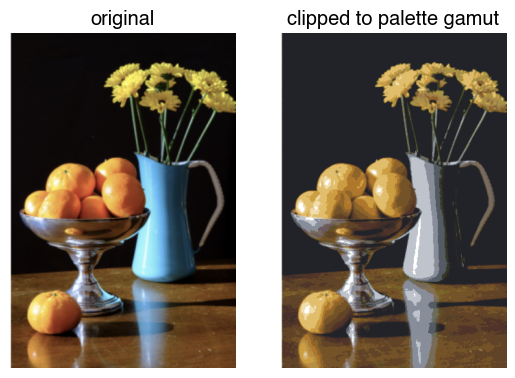

In [202]:
show_projection("oranges.png",["rawsienna","naplesyellow","prussianblue"],show_original=True)

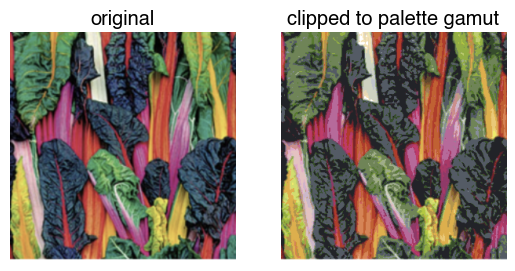

In [203]:
show_projection("chard.png",["alizarin","cadmiumyellow","prussianblue"],show_original=True)

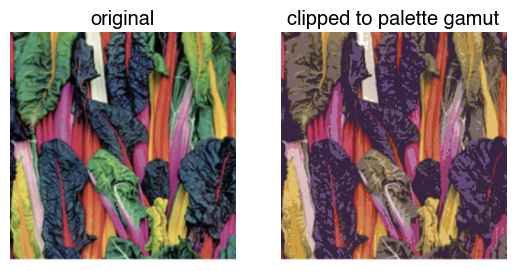

In [224]:
show_projection("chard.png",["alizarin","naplesyellow","cobaltviolet"],show_original=True)

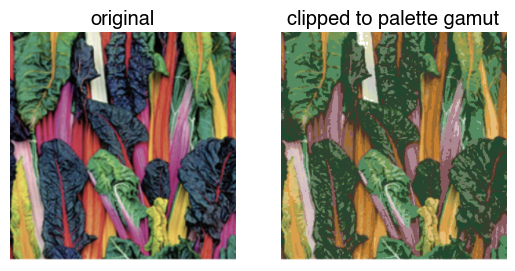

In [226]:
show_projection("chard.png",["cadmiumgreen","saffron","rawsienna"],show_original=True)

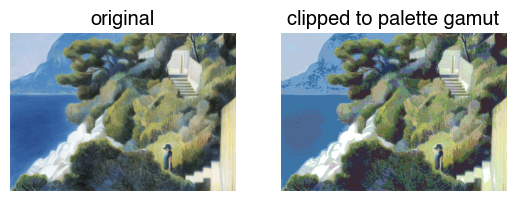

In [215]:
show_projection("cliff.png",["cadmiumyellow","redochre","cobaltblue"],show_original=True)

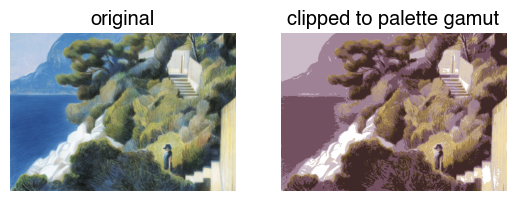

In [208]:
show_projection("cliff.png",["alizarin","naplesyellow","redochre"],show_original=True)

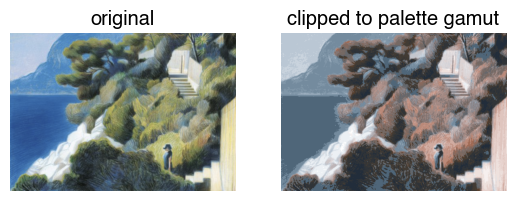

In [238]:
show_projection("cliff.png",["azurite","yellowochre","vandykebrown"],show_original=True)

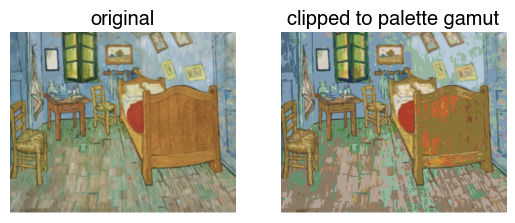

In [209]:
show_projection("vangogh.png",["alizarin","cadmiumyellow","egyptianblue"],show_original=True)

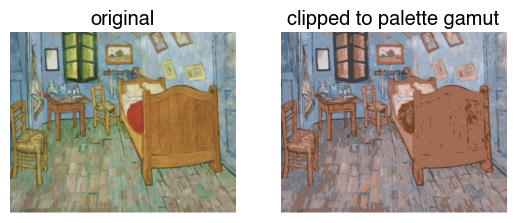

In [233]:
show_projection("vangogh.png",["vandykebrown","yellowochre","cobaltblue"],show_original=True)

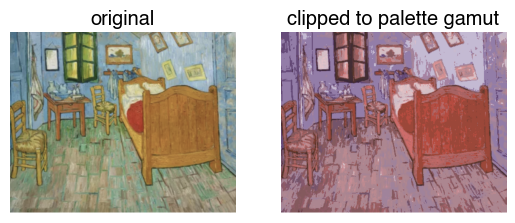

In [239]:
show_projection("vangogh.png",["rawsienna","madderlake","cobaltviolet"],show_original=True)

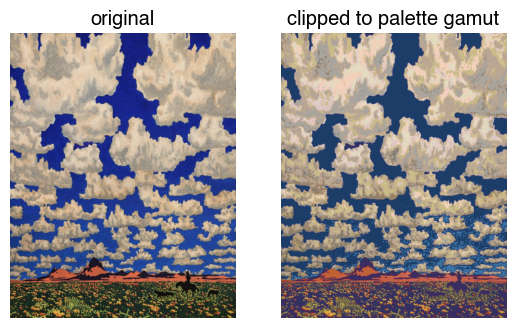

In [212]:
show_projection("clouds.png",["cadmiumyellow","alizarin","cobaltblue"],show_original=True)

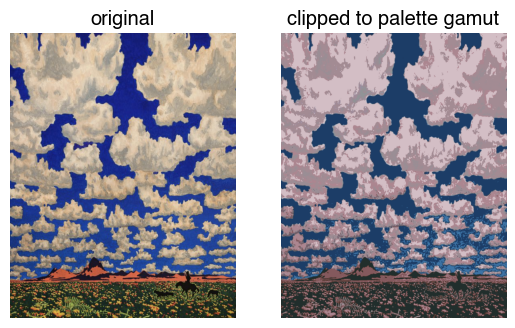

In [231]:
show_projection("clouds.png",["viridian","rawsienna","cobaltblue"],show_original=True)

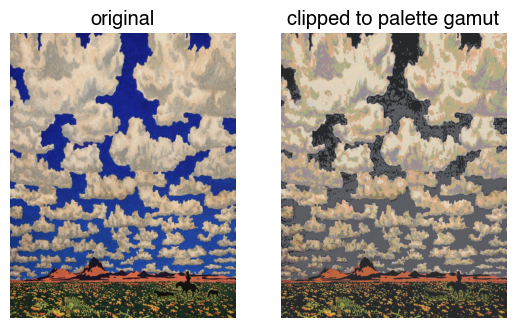

In [225]:
show_projection("clouds.png",["cadmiumyellow","madderlake","lampblaxk"],show_original=True)

<a id='ref'></a>

## References

1. Šárka Sochorová and Ondřej Jamriška. 2021. Practical Pigment Mixing for Digital Painting. ACM Trans. Graph. 40, 6, Article 234 (December 2021), 11 pages. https://doi.org/10.1145/3478513.3480549
2. Antonino Cosentino. 2014. FORS Spectral Database of Historical Pigments in Different Binders. E-conservation Journal 2 (September 2014), 57-68. https://doi.org/10.18236/econs2.201410
3. R. W. G. Hunt. Measuring Colour, 2nd ed. Ellis Horwood Limited, Chichester, 1991.
